## Setup
Load in the data! Also make a set of `politics_tags` to identify political threads. **NOTE** that I lowercase all of the tags. While there are 954,659 unique tags on MetaFilter, the number drops to 197,562 after lower-casing.

In [1]:
%matplotlib inline
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('notebook')

politics_tags = ['election2016', 'election',
                 'potus45', 'DonaldTrump',
                 'BarackObama', 'obama',
                 'trump', 'hillaryclinton',
                 'BernieSanders', 'Clinton',
                 'sanders', 'USPolitics']
politics_tags = set(x.lower() for x in politics_tags)

store = pd.HDFStore('../data/infodump.h5')

## Get politics threads
Use `politics_tags` to identify `politics_threads`

In [2]:
df = store['/mefi/tagdata']
politics_threads = set(df.loc[df.tag_name.\
                              apply(lambda x: x.lower()).\
                              isin(politics_tags), 
                              :].\
                       link_id.unique())

## Get comment count per post
Comments per post are our basic measure. We can always use `politics_threads` to split the comments by how much they have to do with politics or not.

In [3]:
df = store['/mefi/commentdata']

In [4]:
comments_per_post = df.loc[:, ['postid', 'commentid']].\
                       groupby('postid').\
                       count().\
                       rename(columns={'commentid':'comment_count'})

## Plot Comments Over Time
### Comments Per Day
First we group some data

In [12]:
comments_per_day = df.loc[:, ['datestamp', 'commentid']].\
                      set_index('datestamp').\
                      groupby(pd.TimeGrouper('1D')).\
                      count().\
                      rename(columns={'commentid': 'comment_count'}).\
                      fillna(0).reset_index()
comments_per_day.plot(x='datestamp', y='comment_count')

### Rolling Averages
We want to look a bit at trends over time, so calculate rolling averages over four week periods and plot 

In [6]:
avg_comments_per_four_weeks = comments_per_day.set_index('datestamp').\
                                               rolling(28).\
                                               mean().\
                                               reset_index()

avg_comments_per_four_weeks.plot(x='datestamp', y='comment_count')

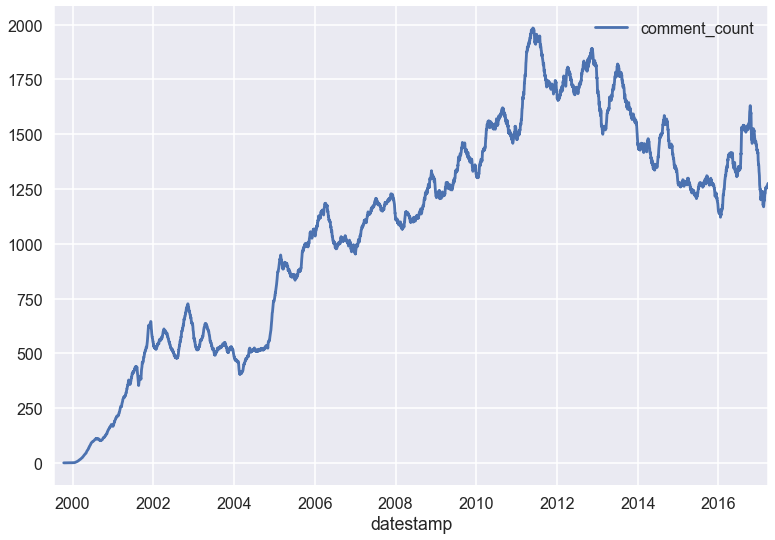

In [16]:
avg_comments_per_ninety = comments_per_day.set_index('datestamp').\
                                           rolling(90).\
                                           mean().\
                                           reset_index()

avg_comments_per_ninety.plot(x='datestamp', y='comment_count')

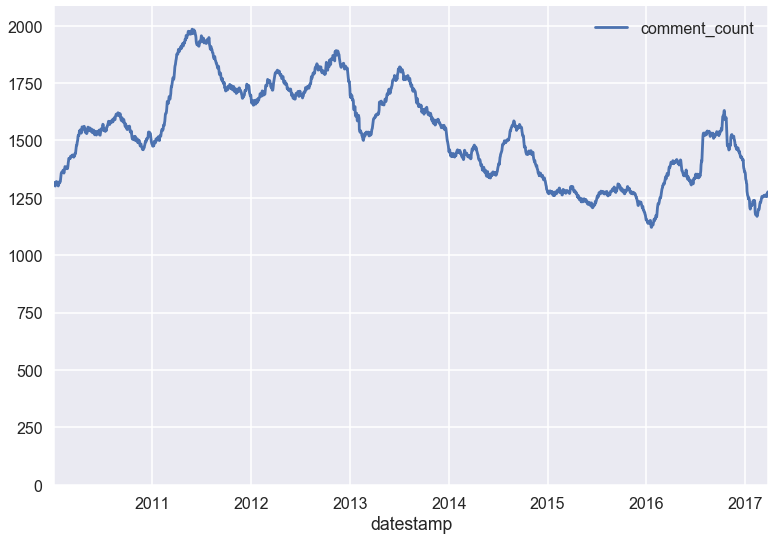

In [23]:
since_2010 = avg_comments_per_ninety.loc[avg_comments_per_ninety.datestamp > dt.datetime(2010, 1, 1), :]
since_2010.plot(x='datestamp', y='comment_count',ylim=(0, since_2010.comment_count.max() + 100))

## Political thread comments relative to all comments
The site's been a lot more political lately. How much of the commentary appears to be going into political threads?

What about *mega-threads*, which we'll say are threads with at least 500 comments in them?

## Political threads relative to all threads
Same question, but just for the threads themselves - how many politics threads have their been relative to other content? Frankly, we'd expect that level to be dropping down.

## User contribution - political threads relative to elsewhere
We don't have any statistics about where users lurk, but we do know where they comment and what they mark as a "favorite" - two limited measures of assessing interaction. How much "interaction" have we seen the users do within these different threads?